In [0]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
#Por favor mover la carpeta que le comparto "evaluacion-semoralesco-master" a su unidad antes de ejecutar este bloque de código
#para asegurar que la ruta especificada en el próximo bloque es correcta
#importación de los contenidos presentes del drive para poder leer los datos a utilizar en el modelo
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Por favor erificar que la ruta efectivamente es la correcta
ubicacion = "/content/drive/My Drive/evaluacion-semoralesco-master/datos/precios"

In [3]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#Lectura de todos los archivos de la carpeta datos
archivos = []
for i in glob.glob("/content/drive/My Drive/evaluacion-semoralesco-master/datos/precios/*"):
    archivos.append(i)

#Se organiza el arreglo de archivos para asegurar que los lea en orden de más viejo a más nuevo
archivos.sort()
#print(archivos)
precio = pd.read_excel(archivos[0],skiprows = 3)

In [0]:
#Se recorren los archivos para determinar el precio con el cual se trabajará en el modelo
for i in range(1,len(archivos)):    
    contador = 0    
    while(True):         
        precio_i = pd.read_excel(archivos[i],skiprows = contador).iloc[:,0:25]          
        if precio_i.columns[0] == 'Fecha':
            break
        elif contador >= 15:
            break
        else:
            contador+=1
    precio = pd.concat([precio,precio_i],ignore_index=True,axis=0)

In [0]:
precio["Fecha"] = pd.to_datetime(precio["Fecha"])
precio = precio.sort_values(by=['Fecha'])
serie = pd.concat([precio["Fecha"],precio.mean(axis=1)],axis=1)

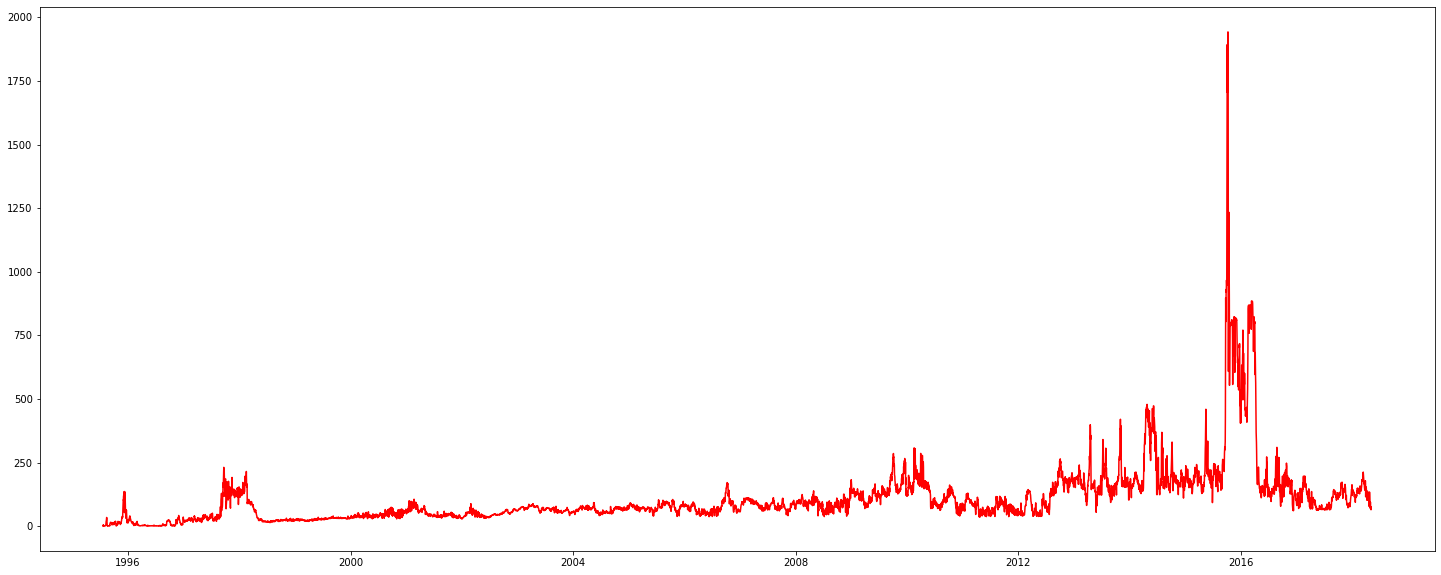

In [8]:
figure(num=None, figsize=(25,10), facecolor='w', edgecolor='k')
plt.plot(serie["Fecha"], serie.iloc[:,1],'r-')
plt.show()

In [0]:
serie = serie.dropna() 
serie = serie.reset_index(drop=True)
serie.columns = ["fecha","price"]

In [0]:
#Normalización de la serie
sc = MinMaxScaler(feature_range = (0, 1))
d = sc.fit_transform(serie["price"].values.reshape(-1,1)).reshape(-1,)

In [0]:
#Adaline
prediccion_dias = 168
tf.enable_eager_execution()

In [0]:
class Model(object):
    def __init__(self, L):      
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

In [0]:
#Definición del retardo óptimo
retardos = [2,3,4,5,6,7,8,9]

def est_retardo(retardos,d):
    lista_retardos = []
    for i in range(len(retardos)):
        l = retardos[i]
        modelo = Model(l)
        y_pred = np.empty(len(d))
        y_pred[:] = np.nan
        for t in range(l, len(d)):
            x = d[t-l:t]
            y_pred[t] = modelo(x)
            modelo.fit(mu=0.05, x=x, y_desired=d[t])
        lista_retardos.append([d[-(prediccion_dias):],y_pred[-(prediccion_dias):]])        
    return lista_retardos
lista_retardos = est_retardo(retardos,d)

In [0]:
mejor_retardo = []
for i in lista_retardos:   
    mejor_retardo.append(metrics.mean_squared_error(i[0],i[1]))

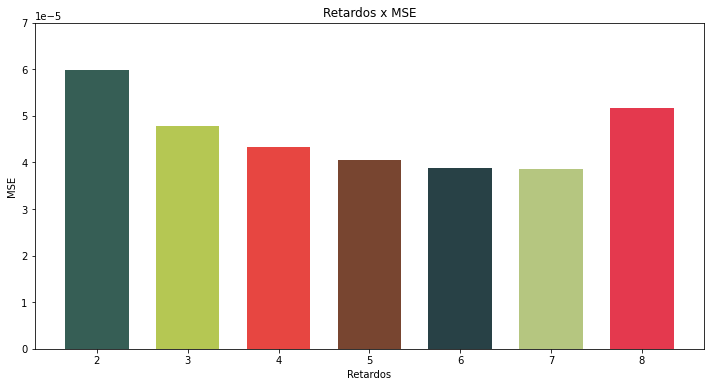

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(["2","3","4","5","6","7","8"],[mejor_retardo[0], mejor_retardo[1], mejor_retardo[2], mejor_retardo[3], mejor_retardo[4], mejor_retardo[5], mejor_retardo[6]], width=0.7, alpha=0.9, color=['#204C42','#ADC140','#E5322C','#693119', '#102C32', '#ADC072', '#E2233B'])
plt.ylim(0,0.00007)
plt.xlabel("Retardos")
plt.ylabel("MSE")
ax.set_title('Retardos x MSE')
plt.show()

Se considera como óptima la opción de 7 retardos

In [0]:
#Definición de la tasa de aprendizaje óptima
ta = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
def est_ta(ta,d):    
    lista_ta = []
    for i in range(len(ta)):    
        l = 6
        modelo = Model(l)
        y_pred = np.empty(len(d))
        y_pred[:] = np.nan
        for t in range(l, len(d)):
            x = d[t-l:t]
            y_pred[t] = modelo(x)
            modelo.fit(mu=ta[i], x=x, y_desired=d[t])
        lista_ta.append([d[-(prediccion_dias):],y_pred[-(prediccion_dias):]])        
    return lista_ta
lista_ta = est_ta(ta,d)

In [0]:
mejor_ta = []
for i in lista_ta:
    mejor_ta.append(metrics.mean_squared_error(i[0],i[1]))

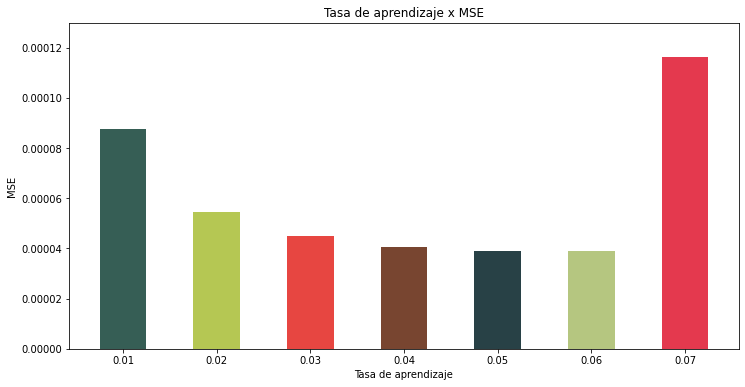

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(["0.01","0.02","0.03","0.04","0.05","0.06","0.07"], [mejor_ta[0], mejor_ta[1], mejor_ta[2], mejor_ta[3], mejor_ta[4], mejor_ta[5], mejor_ta[6]],width=0.5,  alpha=0.9, color=['#204C42','#ADC140','#E5322C','#693119', '#102C32', '#ADC072', '#E2233B'])
plt.ylim(0,0.000130)
plt.xlabel("Tasa de aprendizaje")
plt.ylabel("MSE")
ax.set_title('Tasa de aprendizaje x MSE')
plt.show()

Escogemos como mejor tasa de aprendizaje 0.05

In [0]:
#Se define una función que implementará la técnica adaline en el modelo
def adaline(l,ta,d):
    l = l
    modelo = Model(l)
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan
    for t in range(l, len(d)):
        x = d[t-l:t]
        y_pred[t] = modelo(x)
        modelo.fit(mu=ta, x=x, y_desired=d[t])
    return [d[-(prediccion_dias):],y_pred[-(prediccion_dias):]]
modelo_actual = adaline(7,0.05,d)

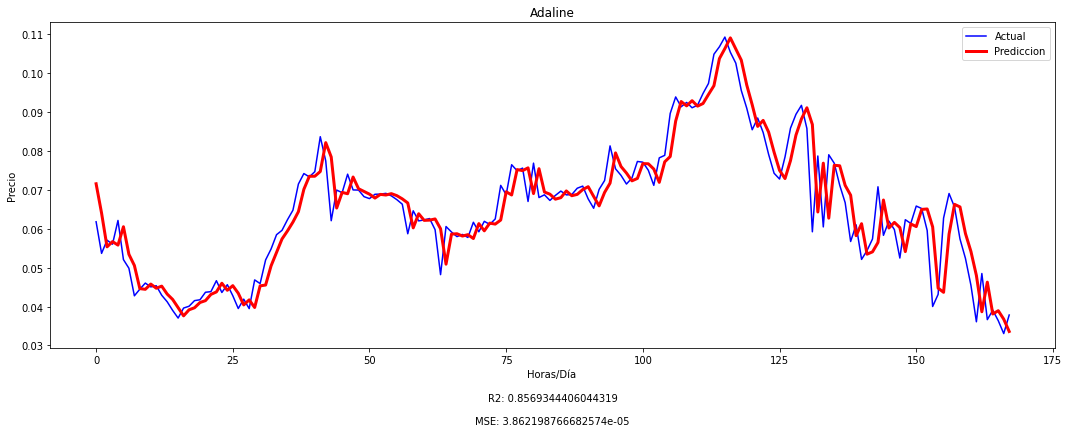

In [20]:
#Se define una función para graficar ambos modelos, y así percibir visualmente si hay una mejora significativa
def modelado(actual,prediccion,nombre):
    figure(figsize=(18,6))
    plt.plot(actual, color = 'blue', label = 'Actual')
    plt.plot(prediccion, color = 'red', label = 'Prediccion',linewidth= 3)
    plt.title(nombre)
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(actual,prediccion))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(actual, prediccion))
              )
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()
modelado(modelo_actual[0],modelo_actual[1],"Adaline")

In [0]:
#Se define una función para determinar matemáticamente si hubo mejora en el modelo o no
def evaluacion_modelo(resultados,parametros):  
    metricas = []
    for i in range(len(resultados)): 
        actual,predoccion = resultados[i][0],resultados[i][1]
        r2 = r2_score(actual,predoccion)
        mse = metrics.mean_squared_error(actual, predoccion)
        metricas.append([r2,mse])
    df = pd.DataFrame(metricas,parametros)
    return df.sort_values(by=[0],ascending=False).iloc[0]

In [0]:
#Aplicando Raíz Cuadrada al retardo
raiz2_serie = sc.fit_transform(serie["price"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)
raiz2_retardos = est_retardo(retardos,raiz2_serie)
raiz2_mejor_retardo = evaluacion_modelo(raiz2_retardos,retardos)
raiz2_mejor_retardo

0    0.849737
1    0.000163
Name: 5, dtype: float64

In [0]:
#Aplicando Raíz Cuadrada a la tasa de aprendizaje
raiz2_ta = est_ta(ta,raiz2_serie)
raiz2_mejor_ta = evaluacion_modelo(raiz2_ta,ta)
raiz2_mejor_ta

0    0.852226
1    0.000160
Name: 0.04, dtype: float64

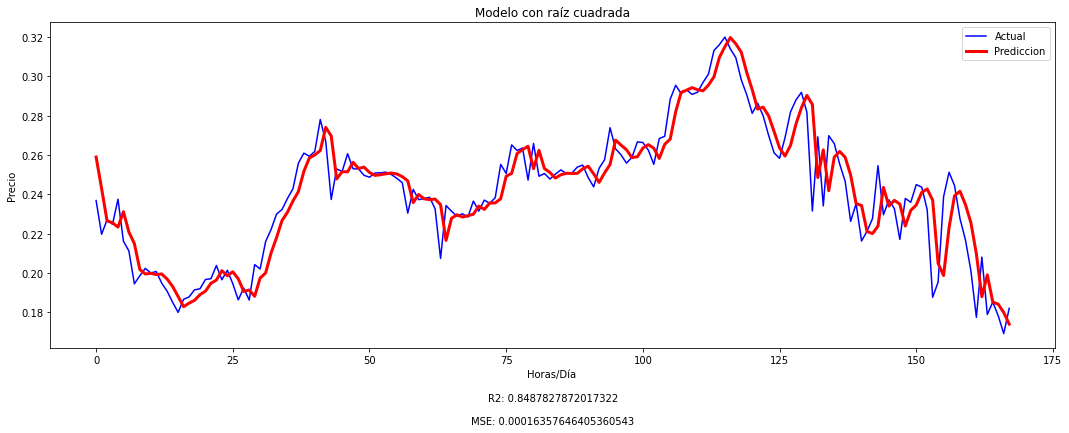

In [0]:
#Modelado aplicando la transormación raíz cuadrada
raiz2_modelo = adaline(5,0.04,raiz2_serie)
modelado(raiz2_modelo[0],raiz2_modelo[1],"Modelo con raíz cuadrada")

In [0]:
ln_retardos = []

In [0]:
#Aplicando logaritmo natural al retardo
ln_serie = sc.fit_transform(np.array(serie["price"].apply(np.log).values).reshape(-1,1)).reshape(-1,)
ln_retardos = est_retardo(retardos,ln_serie)
ln_retardos = evaluacion_modelo(ln_retardos[:-3],retardos[:-3])
ln_retardos

0    0.847960
1    0.000151
Name: 2, dtype: float64

In [0]:
#Aplicando logaritmo natural a la tasa de aprendizaje
ln_ta = est_ta(ta,ln_serie)
ln_mejor_ta = evaluacion_modelo(ln_ta[:-2],ta[:-2])
ln_mejor_ta

0    0.844496
1    0.000154
Name: 0.02, dtype: float64

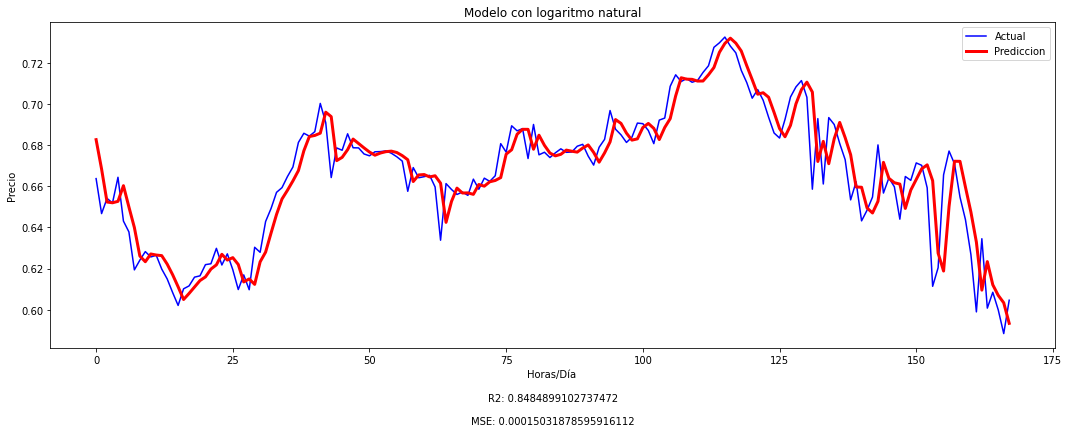

In [0]:
#Modelado aplicando la transormación logaritmo natural
ln_modelo = adaline(2,0.04,ln_serie)
modelado(ln_modelo[0],ln_modelo[1],"Modelo con logaritmo natural")

Como puede apreciarse ninguna de las transformaciones realiza mejoras significativas al modelo, por lo cual lo más conveniente sería usar el modelo sin transformaciones